# Classification (MultiClass) using SVM & Optimal Parameter Selection

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt, matplotlib.image as mpimg
import time 
import warnings
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import seaborn as sns

%matplotlib inline

warnings.filterwarnings('ignore')

## 1. Exploring and Preparing Data


In [2]:
data = pd.read_csv('train.csv')
print('data shape: {}'.format(data.shape))

data shape: (42000, 785)


In [3]:
data.isnull().any(axis=1) ##按行来检查是否存在空值，若存在，则这一行返回True，整个返回结果是一个Series
data.isnull().any(axis=1).describe()

count     42000
unique        1
top       False
freq      42000
dtype: object

<AxesSubplot:xlabel='label', ylabel='count'>

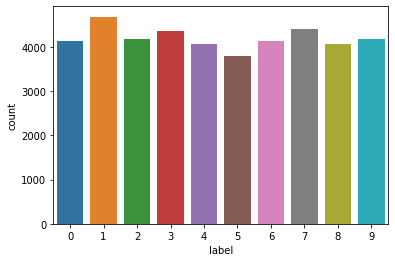

In [4]:
# 下面统计一下每种数据类型有多少
sns.countplot(data.label)

In [5]:
label = data.label
data = data.drop('label',axis=1)
print("Data Shape: ",data.shape)
print("Label Shape: ",label.shape)

Data Shape:  (42000, 784)
Label Shape:  (42000,)


Converting 1D array to 2D 28x28 array using **reshape** , to plot and view grayscale images.

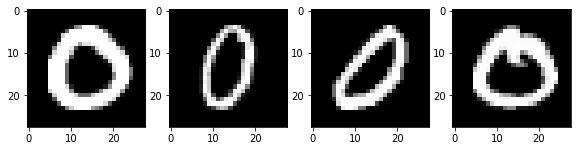

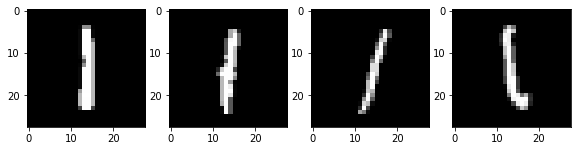

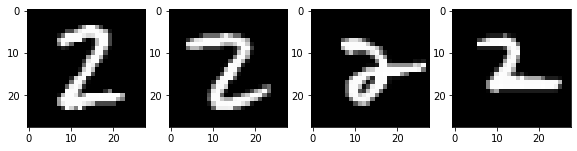

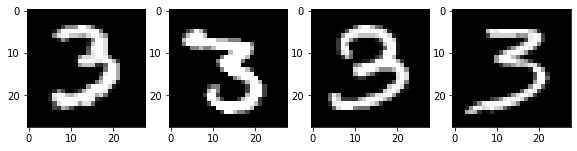

In [6]:
# for x in range(0,4):
#     train_0=data[label==x]
#     data_new=[]
#     for idx in train_0.index:
#         val=train_0.loc[idx].values.reshape(28,28) ## 注意loc是使用index进行索引
#         data_new.append(val)
#     plt.figure(figsize=(25,25))   
#     for x in range(1,5):
#         ax1=plt.subplot(1, 20, x)
#         ax1.imshow(data_new[x],cmap='gray')

for i in range(0,4):
    train_0 = data[label==i]
    plt.figure(figsize=(25,25)) ##创建一个新的figure
    for x in range(1,5):
        ax1 = plt.subplot(1,10,x)
        ax1.imshow(train_0.iloc[x].values.reshape(28,28),cmap='gray')

### Splitting data into Train and Test Data and Labels
Dividing Data randomly into train and test. Out of total train.csv Data, 80% is kept as train for training the model and 20% is kept as test to score the model.

In [7]:
x_train,x_test,y_train,y_test  = train_test_split(data,label,test_size=0.2,random_state=42)
print('train data shape',x_train.shape,y_train.shape)
print('test data shape',x_test.shape,y_test.shape)

train data shape (33600, 784) (33600,)
test data shape (8400, 784) (8400,)


## 2. Support Vector Machine (SVM)
Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression problems. It performs classification by finding the hyperplane that maximizes the margin between the two classes.

## 3. Classification using SVM
Using SVM Classifier from **sklearn** library.
We have 33600 training samples, fitting all of them will take a lot of time. To keep it simple for now, lets select 5000 out of them.
You can change the value i to use the desired number of samples.

In [8]:
index = {}
train_size  =5000
fit_time = []
score_time =  []
model = svm.SVC(C=0.8,kernel='rbf',decision_function_shape='ovr',random_state=250)

### Case 1 - Gray Scale Images
Fitting train data and finding a score for test data to check model performance

In [9]:
fit_time.append(time.time())
model.fit(x_train[:train_size],y_train[:train_size].values)
fit_time.append(time.time())
fittime=fit_time[1]-fit_time[0]
print('Time consumed to fit model: ',time.strftime('%H:%M:%S',time.gmtime(fittime)))
score_time.append(time.time())
score = model.score(x_test,y_test)
print('Accuracy for grayscale:',score)
score_time.append(time.time())
scoretime = score_time[1]-score_time[0]
print('Time consumed for accuracy : ',time.strftime('%H:%M:%S',time.gmtime(scoretime)))
predictions = model.predict(x_test)

Time consumed to fit model:  00:00:14
Accuracy for grayscale: 0.9485714285714286
Time consumed for accuracy :  00:01:47


In [10]:
index['case1_rbf_scalegray'] = [fittime,score,scoretime,predictions]

### Case 2 - Binary Images
To simply the problem, converting images to black and white from gray scale by replacing all values > 0 to 1. 
And Converting 1D array to 2D 28x28 array using **reshape** , to plot and view **binary** images.

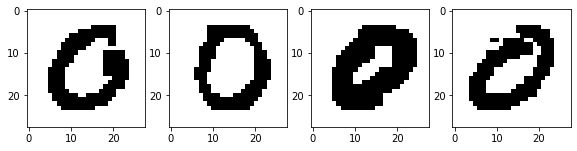

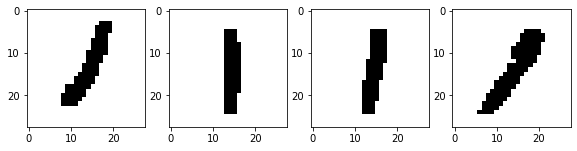

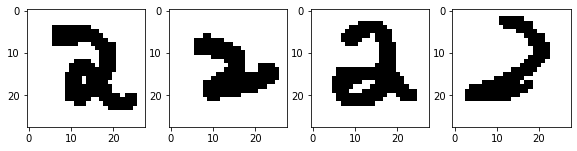

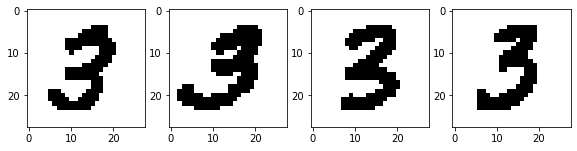

In [11]:
x_train_b = x_train
x_train_b[x_train_b>0] = 1
x_test_b = x_test
x_test_b[x_test>0] = 1

for x in range(0,4):
    plt.figure(figsize=(25,25))
    train_0 = x_train_b[label==x]
    for i in range(1,5):
        ax = plt.subplot(1,10,i)
        ax.imshow(train_0.iloc[i].values.reshape(28,28),cmap='binary')

In [31]:
fit_start_time = time.time()
model.fit(x_train_b[:train_size],y_train[:train_size].values)
fittime =  time.time() - fit_start_time
print('Time consumed to fit model: ',time.strftime('%H:%M:%S',time.gmtime(fittime)))
score_start_time = time.time()
score = model.score(x_test_b,y_test.values)
print('Accuracy for binary:',score)
score_time = time.time() -score_start_time
print('Time consumed for accuracy : ',time.strftime('%H:%M:%S',time.gmtime(score_time)))
predictions = model.predict(x_test_b)

Time consumed to fit model:  00:00:03
Accuracy for binary: 0.9461904761904761
Time consumed for accuracy :  00:00:18


In [32]:
index['case2_rbf_binary'] = [fittime,score,scoretime,predictions]

It can be seen that for the chosen training samples, accuracy of Case 2 (91%) is much higher than Case 1 (9.3%).

However, the high dimensionality of data is making computational time high. Lets reduce the dimensions using PCA (Principal Component Analysis)

### Case 3 - GrayScale + Dimensionality Reduction - PCA 
It is a linear transformation technique used to identify strong patterns in data by finding out variable correlation. It maps the data to a lower dimensional subspace in a way that data variance is maximized while retaining most of the information.

Here, Data is standardized and PCA is performed on data with all the components. Then variance is plotted for all components to decide which components to remove.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA

std_scaler = StandardScaler().fit(x_train)
x_train_std = std_scaler.transform(x_train)
x_test_std = std_scaler.transform(x_test)

sklearn_pca = sklearnPCA().fit(x_train_std)
x_train_pca = sklearn_pca.transform(x_train_std)
x_test_pca = sklearn_pca.transform(x_test_std)

#pca的方差信息2w
var_per = sklearn_pca.explained_variance_ratio_
cum_var_per = sklearn_pca.explained_variance_ratio_.cumsum()

In [15]:
np.savetxt('var_per.csv',var_per)
np.savetxt('cum_var_per.csv',cum_var_per)

In [16]:
#Keeping 90% of information by choosing components falling within 0.90 cumulative.
l = len(cum_var_per[cum_var_per <=0.9])
sklearn_pca = sklearnPCA(n_components=l)
x_train_pca = sklearn_pca.fit_transform(x_train_std)
x_test_pca = sklearn_pca.transform(x_test_std)
print('shape with pca on train : ','befor pca:',x_train_std.shape,'after pca',x_train_pca.shape)
print('shape with pca on test : ','befor pca:',x_test_std.shape,'after pca',x_test_pca.shape)

shape with pca on train :  befor pca: (33600, 784) after pca (33600, 288)
shape with pca on test :  befor pca: (8400, 784) after pca (8400, 288)


In [17]:
start_time = time.time()
model.fit(x_train_pca[:train_size],y_train[:train_size].values)
fittime = time.time()-start_time
print('fit time: ',time.strftime('%H:%M:%S',time.gmtime(fittime)))
score_start_time = time.time()
score = model.score(x_test_pca,y_test.values)
scoretime = time.time()-score_start_time
print('accuracy of pca:',score)
print('score time: ',time.strftime('%H:%M:%S',time.gmtime(scoretime)))
predictions = model.predict(x_test_pca)

fit time:  00:00:07
accuracy of pca: 0.9269047619047619
score time:  00:00:29


In [18]:
index['case3_rbf_pca'] = [fittime,score,scoretime,predictions]

### Case 4 - Binary + Dimensionality Reduction - PCA 

In [19]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler().fit(x_train_b)
x_train_b_std = std_scaler.transform(x_train_b)
x_test_b_std = std_scaler.transform(x_test_b)

sklearn_pca = sklearnPCA().fit(x_train_b_std)
x_train_b_pca = sklearn_pca.transform(x_train_b_std)
x_test_b_pca = sklearn_pca.transform(x_test_b_std)

var_per = sklearn_pca.explained_variance_ratio_
cum_var_per = sklearn_pca.explained_variance_ratio_.cumsum()

In [20]:
import numpy as np
np.savetxt('var_per_b.csv',var_per)
np.savetxt('cum_var_per_b.csv',cum_var_per)

In [21]:
l = len(cum_var_per[cum_var_per <= 0.9])
sklearn_pca = sklearnPCA(n_components=l).fit(x_train_b_std)
x_train_b_pca = sklearn_pca.transform(x_train_b_std)
x_test_b_pca = sklearn_pca.transform(x_test_b_std)
print('shape with pca&binary on train  : ','befor pca:',x_train_b_std.shape,'after pca',x_train_b_pca.shape)
print('shape with pca&binary on test : ','befor pca:',x_test_b_std.shape,'after pca',x_test_b_pca.shape)


shape with pca&binary on train  :  befor pca: (33600, 784) after pca (33600, 288)
shape with pca&binary on test :  befor pca: (8400, 784) after pca (8400, 288)


In [22]:
start_time = time.time()
model.fit(x_train_b_pca[:train_size],y_train[:train_size].values)
fittime = time.time()-start_time
print('fit time: ',time.strftime('%H:%M:%S',time.gmtime(fittime)))
score_start_time = time.time()
score = model.score(x_test_b_pca,y_test.values)
scoretime = time.time()-score_start_time
print('accuracy of pca:',score)
print('score time: ',time.strftime('%H:%M:%S',time.gmtime(scoretime)))
predictions = model.predict(x_test_b_pca)

fit time:  00:00:07
accuracy of pca: 0.9267857142857143
score time:  00:00:35


In [23]:
index['case4_rbf_binary_pca'] = [fittime,score,scoretime,predictions]

### Comparison of 4 Cases

In [24]:
for key,item in index.items():
    print(key,item)

case1_rbf_scalegray [14.892323732376099, 0.9485714285714286, 107.4933934211731, array([8, 1, 9, ..., 3, 0, 9], dtype=int64)]
case2_rbf_binary [10.048444509506226, 0.9461904761904761, 107.4933934211731, array([6, 5, 3, ..., 2, 6, 0], dtype=int64)]
case3_rbf_pca [7.435245513916016, 0.9269047619047619, 29.95643663406372, array([8, 1, 9, ..., 3, 0, 9], dtype=int64)]
case4_rbf_binary_pca [7.860432863235474, 0.9267857142857143, 35.57978892326355, array([8, 1, 9, ..., 3, 0, 9], dtype=int64)]


**Observations:**

+ By simplifying the problem in Case 2 (by converting images to binary), accuracy increases from 9%~ to 91%~ for the chosen number of samples.
+ By reducing dimensions in Case3 and Case4, fitting time reduces drastically.

8400
8400
8400
8400


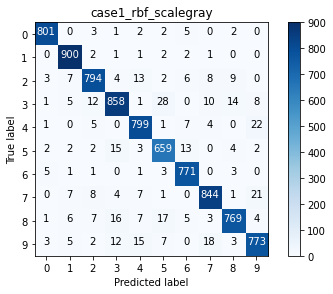

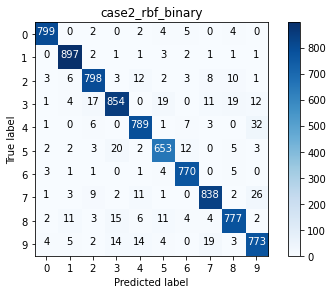

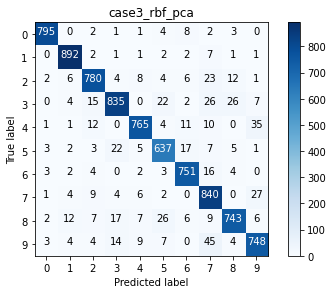

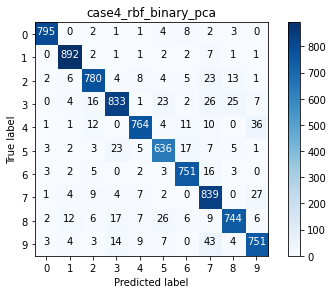

In [35]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # 设定图片有多少行，多少列，用于后面向每个格子中填充数据
    plt.imshow(cm, cmap=cmap)  # 四舍五入 interpolation='nearest'

    # 设置标题，以及颜色条
    plt.title(title)
    plt.colorbar()

    # 分为设置x方向和y方向有多少个分类，以及每个分类显示的名称
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    # 判断是否需要归一化
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.metrics import confusion_matrix
for key,item in index.items():
    plt.figure()
    print(len(item[3]))
    confusion_mtx = confusion_matrix(y_test,item[3])
    plot_confusion_matrix(confusion_mtx, classes=range(10),title=key)

KeyError: 426

<Figure size 432x288 with 0 Axes>

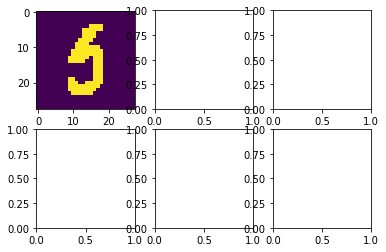

In [53]:
def display_errors(error_index, x_errors, predicted_errors, y_true,title = 'error'):
    n = 0
    n_rows = 2
    n_cols = 3

    fig, ax = plt.subplots(n_rows, n_cols)
    for row in range(n_rows):
        for col in range(n_cols):
            index = error_index[n]
            ax[row, col].imshow(x_errors.iloc[index].values.reshape(28, 28))
            ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(
                predicted_errors[index], y_true[index]))

            n += 1
    fig.tight_layout()


for key,item in index.items():
    plt.figure()
    errors = (item[3] - y_test != 0)
    pred_classes_errors = item[3][errors]  # 预测后的值（预测错误的部分）
    image_errors = x_test[errors]  # 对应的像素
    true_classes_errors = y_test[errors].values  # 真实的值
    error_idx = np.random.randint(low=0, high=len(pred_classes_errors), size=6)  # 取六个随机数
    display_errors(error_idx, image_errors,
                pred_classes_errors, true_classes_errors,title=key)

## 4. Training Data Size Vs Accuracy , Fitting & Score Times
Understanding how training data size affects accuracy.

In [25]:
from tqdm import tqdm

fit_time=[]
score=[]
score_time=[]
for j in tqdm(range(1000,31000,5000)):
    start_time = time.time()
    model.fit(x_train_b_pca[:j], y_train[:j].values.ravel())
    fit_time.append(time.time() - start_time)
    start_time = time.time()
    score.append(model.score(x_train_b_pca,y_train))
    score_time.append(time.time() - start_time)

 83%|████████▎ | 5/6 [12:45<02:33, 153.17s/it]


KeyboardInterrupt: 

100%|██████████| 6/6 [00:00<?, ?it/s]


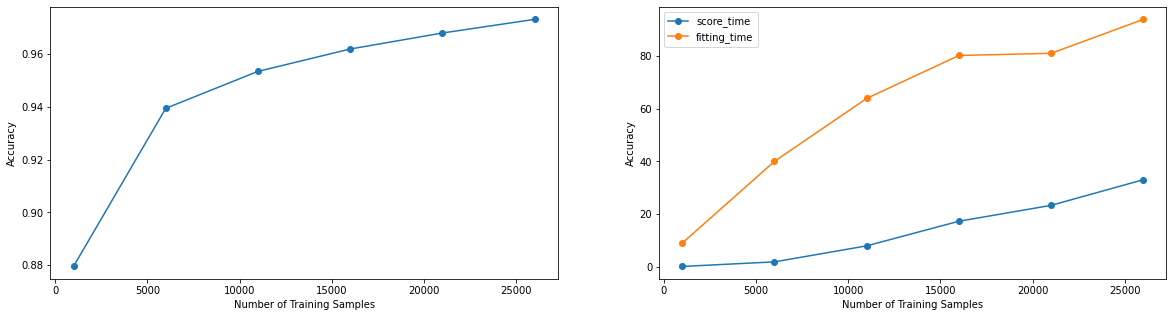

In [ ]:
x = list(tqdm(range(1000,31000,5000)))

plt.figure(figsize=(20,5))
ax1= plt.subplot(1,2,1)
ax1.plot(x,score,'-o')
ax1.set_xlabel('Number of Training Samples')
ax1.set_ylabel('Accuracy')

ax2= plt.subplot(1,2,2)
ax2.plot(x,fit_time,'-o')
ax2.plot(x,score_time,'-o')
ax2.set_xlabel('Number of Training Samples')
ax2.set_ylabel('Accuracy')
ax2.legend(['score_time','fitting_time'])



## 5. Parameter Selection for SVM using GridSearchCV
Out of parameters below, we will be playing with **Gamma** and **C**, where

**Gamma** is the parameter of a Gaussian Kernel (to handle non-linear classification)

**C** is the parameter for the soft margin cost function, also known as cost of misclassification. 

A large **C** gives you low bias and high variance and vice versa.

To find optimal combination of parameters to achieve maximum accuracy ,using **GridSearchCV** from sklearn library. GridSearchCV does exhaustive search over specified parameter values for an estimator. 

Storing values of parameters to be passed to GridSearchCV in **parameters**, keeping cross-validation folds as 3 and passing SVM as estimator.

In [ ]:
model.get_params()

{'C': 0.8,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 250,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
parameters = {
    'gamma':[1,0.1,0.01,0.001],
    'C':[1000,100,10,1]
}
models = GridSearchCV(model,param_grid=parameters,cv=3)

In [ ]:
#For Case 4 (Binary Images and PCA Reduction):
X=x_train_b_pca[:train_size]
Y=y_train[:train_size]
start_time = time.time()
models.fit(X,Y.values)
fittime = time.time()-start_time
print('time consumed for GridSearchCV: ',time.strftime('%H:%M:%S',time.gmtime(fittime)))

time consumed for GridSearchCV:  00:02:58


In [ ]:
print("Scores for all Parameter Combination: \n",models.cv_results_['mean_test_score'])
print("\nOptimal C and Gamma Combination: ",models.best_params_)
print("\nMaximum Accuracy acheieved on LeftOut Data: ",models.best_score_)

Scores for all Parameter Combination: 
 [0.11300009 0.18160005 0.78139702 0.92719871 0.11300009 0.18160005
 0.78139702 0.92719871 0.11300009 0.18160005 0.78139702 0.92999935
 0.11220001 0.17620005 0.76259622 0.91999775]

Optimal C and Gamma Combination:  {'C': 10, 'gamma': 0.001}

Maximum Accuracy acheieved on LeftOut Data:  0.9299993542708025


In [ ]:
#To verify, lets pass the optimal parameters to Classifier and check the score.
C=models.best_params_['C']
gamma=models.best_params_['gamma']
clf=svm.SVC(C=C,gamma=gamma, random_state=42)

In [ ]:
start_time = time.time()
model.fit(x_train_b_pca[:train_size], y_train[:train_size].values.ravel())
elapsed_time = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print("Accuracy for binary: ",model.score(x_train_b_pca[:train_size], y_train[:train_size].values.ravel()))

Time consumed to fit model:  00:00:01
Accuracy for binary:  0.9756


It can be seen that for the chosen training samples, accuracy of Case 2 has increased from (91%~) to (93.7%) for the optimal parameters.
Now using all training samples:

In [41]:
start_time = time.time()
clf.fit(x_train_b_pca[:train_size], y_train[:train_size].values.ravel())
elapsed_time = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print("Accuracy for binary: ",clf.score(x_train_b_pca[:train_size], y_train[:train_size].values.ravel()))

Time consumed to fit model:  00:00:00
Accuracy for binary:  0.998
